<a href="https://colab.research.google.com/github/Daniel-Benson-Poe/DS-Unit-2-Applied-Modeling/blob/master/db_LS_DS_234_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science

*Unit 2, Sprint 3, Module 4*

---

# Model Interpretation

You will use your portfolio project dataset for all assignments this sprint.

## Assignment

Complete these tasks for your project, and document your work.

- [ ] Continue to iterate on your project: data cleaning, exploratory visualization, feature engineering, modeling.
- [ ] Make at least 1 partial dependence plot to explain your model.
- [ ] Make at least 1 Shapley force plot to explain an individual prediction.
- [ ] **Share at least 1 visualization (of any type) on Slack!**

If you aren't ready to make these plots with your own dataset, you can practice these objectives with any dataset you've worked with previously. Example solutions are available for Partial Dependence Plots with the Tanzania Waterpumps dataset, and Shapley force plots with the Titanic dataset. (These datasets are available in the data directory of this repository.)

Please be aware that **multi-class classification** will result in multiple Partial Dependence Plots (one for each class), and multiple sets of Shapley Values (one for each class).

## Stretch Goals

#### Partial Dependence Plots
- [ ] Make multiple PDPs with 1 feature in isolation.
- [ ] Make multiple PDPs with 2 features in interaction. 
- [ ] Use Plotly to make a 3D PDP.
- [ ] Make PDPs with categorical feature(s). Use Ordinal Encoder, outside of a pipeline, to encode your data first. If there is a natural ordering, then take the time to encode it that way, instead of random integers. Then use the encoded data with pdpbox. Get readable category names on your plot, instead of integer category codes.

#### Shap Values
- [ ] Make Shapley force plots to explain at least 4 individual predictions.
    - If your project is Binary Classification, you can do a True Positive, True Negative, False Positive, False Negative.
    - If your project is Regression, you can do a high prediction with low error, a low prediction with low error, a high prediction with high error, and a low prediction with high error.
- [ ] Use Shapley values to display verbal explanations of individual predictions.
- [ ] Use the SHAP library for other visualization types.

The [SHAP repo](https://github.com/slundberg/shap) has examples for many visualization types, including:

- Force Plot, individual predictions
- Force Plot, multiple predictions
- Dependence Plot
- Summary Plot
- Summary Plot, Bar
- Interaction Values
- Decision Plots

We just did the first type during the lesson. The [Kaggle microcourse](https://www.kaggle.com/dansbecker/advanced-uses-of-shap-values) shows two more. Experiment and see what you can learn!

# Read in data, Clean, Wrangle, Feature-Engineering

In [0]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/Daniel-Benson-Poe/practice_datasets/master/'
    !pip install category_encoders==2.*
    !pip install pandas-profiling==2.*
    !pip install eli5
    !pip install pdpbox
    !pip install shap

# If you're working locally:
else:
    DATA_PATH = '../data/'

In [0]:
# Read in data
import pandas as pd
suicide_df = pd.read_csv(DATA_PATH+'suicide_rates.csv')

In [0]:
# General Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sbn
from scipy.stats import ttest_ind, ttest_1samp, t, randint, uniform
import pandas_profiling
from pandas_profiling import ProfileReport
import category_encoders as ce 
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, plot_confusion_matrix, confusion_matrix, classification_report, r2_score, mean_absolute_error, mean_squared_error
from sklearn.linear_model import LinearRegression

In [110]:
suicide_df.head()

,country,year,sex,age,suicides_no,population,suicides/100k pop,country-year,HDI for year,gdp_for_year ($),gdp_per_capita ($),generation
0,Albania,1987,male,15-24 years,21,312900,6.71,Albania1987,NaN,"2,156,624,900",796,Generation X
1,Albania,1987,male,35-54 years,16,308000,5.19,Albania1987,NaN,"2,156,624,900",796,Silent
2,Albania,1987,female,15-24 years,14,289700,4.83,Albania1987,NaN,"2,156,624,900",796,Generation X
3,Albania,1987,male,75+ years,1,21800,4.59,Albania1987,NaN,"2,156,624,900",796,G.I. Generation
4,Albania,1987,male,25-34 years,9,274300,3.28,Albania1987,NaN,"2,156,624,900",796,Boomers


In [111]:
(suicide_df['suicides_no'] / suicide_df['population'] * 100) 

0        0.006711
1        0.005195
2        0.004833
3        0.004587
4        0.003281
           ...   
27815    0.002955
27816    0.002583
27817    0.002172
27818    0.001672
27819    0.001459
Length: 27820, dtype: float64

In [112]:
suicide_df.shape

(27820, 12)

In [113]:
# Check dtypes
suicide_df.describe(include='number')

,year,suicides_no,population,suicides/100k pop,HDI for year,gdp_per_capita ($)
count,27820.000000,27820.000000,2.782000e+04,27820.000000,8364.000000,27820.000000
mean,2001.258375,242.574407,1.844794e+06,12.816097,0.776601,16866.464414
std,8.469055,902.047917,3.911779e+06,18.961511,0.093367,18887.576472
min,1985.000000,0.000000,2.780000e+02,0.000000,0.483000,251.000000
25%,1995.000000,3.000000,9.749850e+04,0.920000,0.713000,3447.000000
50%,2002.000000,25.000000,4.301500e+05,5.990000,0.779000,9372.000000
75%,2008.000000,131.000000,1.486143e+06,16.620000,0.855000,24874.000000
max,2016.000000,22338.000000,4.380521e+07,224.970000,0.944000,126352.000000


In [114]:
suicide_df.describe(exclude='number')

,country,sex,age,country-year,gdp_for_year ($),generation
count,27820,27820,27820,27820,27820,27820
unique,101,2,6,2321,2321,6
top,Mauritius,male,75+ years,Trinidad and Tobago2003,"271,811,088,781",Generation X
freq,382,13910,4642,12,12,6408


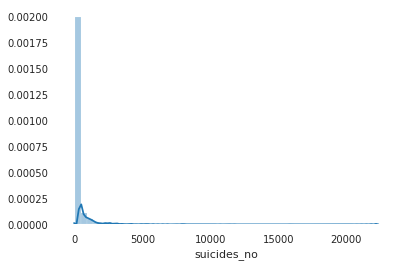

In [115]:
# Check for right-skewedness
import seaborn as sns
target = 'suicides_no'
y = suicide_df[target]
sns.distplot(y);

In [0]:
# The target is heavily right skewed, so log transform the target
import numpy as np
y = np.log1p(y)

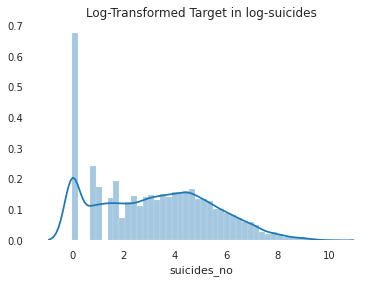

In [117]:
# Check target dist plot again
sns.distplot(y);
plt.title("Log-Transformed Target in log-suicides");

In [0]:
# Log transform target data
suicide_df[target] = np.log1p(suicide_df[target])

In [119]:
# Create train set out of data from all years prior to 2015
train = suicide_df[suicide_df['year'] < 2015]

# Create validation set out of data from the year 2015
val = suicide_df[suicide_df['year'] == 2015]

# Create test set out of data from the year 2016
test = suicide_df[suicide_df['year'] == 2016]

train.shape, val.shape, test.shape

((26916, 12), (744, 12), (160, 12))

In [0]:
def char_eraser(df, column, chars):
  df = df[column].replace(chars, '')
  return df

In [0]:
# Create function to wrangle data
def wrangle(X):
  """Wrangles the train, validation, and test sets the same way."""

  # Prevent SettingWithCopyWarning
  X = X.copy()

  # Change column names: replace spaces with underscores
  cols_to_name = ['suicides_no', 'suicides/100k pop', 'country-year', 
                  'HDI for year', ' gdp_for_year ($) ', 'gdp_per_capita ($)']
  new_col_names = ['log_num_suicides', 'suicides/100k_pop', 'country_year', 
                   'HDI_for_year', 'annual_gdp', 'gdp_per_capita']
  i = 0
  for col in cols_to_name:
    X = X.rename(columns={col: new_col_names[i]})
    i += 1
  
  # Remove commas from the values in annual_gdp column and convert the values to integers
  X['annual_gdp'] = X.apply(char_eraser, axis=1, args=('annual_gdp', ',')).astype(int)

  # Remove the ' years' string in the age column
  X['age'] = X.apply(char_eraser, axis=1, args=('age', ' years'))


  # Drop the country_year and HDI_for_year columns
  garbage_columns = ['country_year', 'HDI_for_year']
  X = X.drop(columns=garbage_columns)

  # Drop suicides/100k_pop to remove possible leakage
  X = X.drop(columns='suicides/100k_pop')

  return X

train = wrangle(train)
val = wrangle(val)
test = wrangle(test)
  

  

In [122]:
train.head()

,country,year,sex,age,log_num_suicides,population,annual_gdp,gdp_per_capita,generation
0,Albania,1987,male,15-24,3.091042,312900,2156624900,796,Generation X
1,Albania,1987,male,35-54,2.833213,308000,2156624900,796,Silent
2,Albania,1987,female,15-24,2.708050,289700,2156624900,796,Generation X
3,Albania,1987,male,75+,0.693147,21800,2156624900,796,G.I. Generation
4,Albania,1987,male,25-34,2.302585,274300,2156624900,796,Boomers


In [123]:
train.shape, val.shape, test.shape

((26916, 9), (744, 9), (160, 9))

# Create Baseline Model and a Random Forest Regressor Model

In [0]:
# Set target
target = 'log_num_suicides'

# Arrange data into X features matrix and y target vector
X_train = train.drop(columns=target)
y_train = train[target]
X_val = val.drop(columns=target)
y_val = val[target]
X_test = test.drop(columns=target)
y_test = test[target]

In [125]:
train.isnull().sum(), val.isnull().sum(), test.isnull().sum()

(country             0
 year                0
 sex                 0
 age                 0
 log_num_suicides    0
 population          0
 annual_gdp          0
 gdp_per_capita      0
 generation          0
 dtype: int64, country             0
 year                0
 sex                 0
 age                 0
 log_num_suicides    0
 population          0
 annual_gdp          0
 gdp_per_capita      0
 generation          0
 dtype: int64, country             0
 year                0
 sex                 0
 age                 0
 log_num_suicides    0
 population          0
 annual_gdp          0
 gdp_per_capita      0
 generation          0
 dtype: int64)

In [126]:
# Fit train data into a decisiontreeregressor model to create a baseline

from sklearn.tree import DecisionTreeRegressor

pipeline = make_pipeline(
    ce.OrdinalEncoder(),
    StandardScaler(),
    DecisionTreeRegressor(random_state=42, max_depth=2)
)

pipeline.fit(X_train, y_train)
score = pipeline.score(X_val, y_val)
print(f"Baseline Validation R^2: {score}")

Baseline Validation R^2: 0.6341308766172064


In [127]:
# Now fit a random forest regressor to see if accuracy score increases

from sklearn.ensemble import RandomForestRegressor

pipeline = make_pipeline(
    ce.OrdinalEncoder(),
    StandardScaler(),
    RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
)

pipeline.fit(X_train, y_train)
score = pipeline.score(X_val, y_val)
print(f"Random Forest R^2: {score}")

Random Forest R^2: 0.9741531818957533


In [128]:
X_train.columns, X_val.columns, X_test.columns

(Index(['country', 'year', 'sex', 'age', 'population', 'annual_gdp',
        'gdp_per_capita', 'generation'],
       dtype='object'),
 Index(['country', 'year', 'sex', 'age', 'population', 'annual_gdp',
        'gdp_per_capita', 'generation'],
       dtype='object'),
 Index(['country', 'year', 'sex', 'age', 'population', 'annual_gdp',
        'gdp_per_capita', 'generation'],
       dtype='object'))

# Use permutation to find importances

In [129]:
# Remake pipeline to exclude random forest regressor because permutation does not play well with others
 transformers = make_pipeline(
     ce.OrdinalEncoder(),
     StandardScaler()
 )

 X_train_transformed = transformers.fit_transform(X_train, y_train)
 X_val_transformed = transformers.transform(X_val)

 model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
 model.fit(X_train_transformed, y_train)

 

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=-1, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)

In [130]:
# instantiate and fit permuter
import eli5
from eli5.sklearn import PermutationImportance

permuter = PermutationImportance(
    model, 
    scoring='r2',
    n_iter=5,
    random_state=42
)

permuter.fit(X_val_transformed, y_val)

PermutationImportance(cv='prefit',
                      estimator=RandomForestRegressor(bootstrap=True,
                                                      ccp_alpha=0.0,
                                                      criterion='mse',
                                                      max_depth=None,
                                                      max_features='auto',
                                                      max_leaf_nodes=None,
                                                      max_samples=None,
                                                      min_impurity_decrease=0.0,
                                                      min_impurity_split=None,
                                                      min_samples_leaf=1,
                                                      min_samples_split=2,
                                                      min_weight_fraction_leaf=0.0,
                                                      n_estimators=100

In [131]:
feature_names = X_val.columns.to_list()
pd.Series(permuter.feature_importances_, feature_names).sort_values(ascending=True)

year              0.000000
generation        0.018085
gdp_per_capita    0.028020
annual_gdp        0.042205
country           0.093242
sex               0.156306
age               0.369702
population        1.386888
dtype: float64

In [132]:
eli5.show_weights(permuter,
                  top=None, # How many best feature to display. None = all
                  feature_names=feature_names)

Weight,Feature
1.3869 ± 0.0561,population
0.3697 ± 0.0310,age
0.1563 ± 0.0135,sex
0.0932 ± 0.0102,country
0.0422 ± 0.0102,annual_gdp
0.0280 ± 0.0049,gdp_per_capita
0.0181 ± 0.0017,generation
0 ± 0.0000,year


# Use permutation scores for feature selection purposes

In [133]:
print(f"Shape before removing features: {X_train.shape}")

Shape before removing features: (26916, 8)


In [0]:
minimum_importance = 0.0181
mask = permuter.feature_importances_ > minimum_importance
features = X_train.columns[mask]
X_train = X_train[features]

In [135]:
print(f"Shape after removing features: {X_train.shape}")

Shape after removing features: (26916, 6)


In [136]:
X_val = X_val[features]

pipeline = make_pipeline(
    ce.OrdinalEncoder(),
    SimpleImputer(strategy='median'),
    RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
)

pipeline.fit(X_train, y_train)
score = pipeline.score(X_val, y_val)
print(f"R^2 after permutation: {score}")

R^2 after permutation: 0.9719952754788912


# Use xgboost for gradient boosting

In [137]:
from xgboost import XGBRegressor

pipeline = make_pipeline(
    ce.OrdinalEncoder(),
    StandardScaler(),
    XGBRegressor(n_estimators=100, random_state=42, n_jobs=-1)
)

pipeline.fit(X_train, y_train)

[23:39:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


Pipeline(memory=None,
         steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['country', 'sex', 'age'],
                                drop_invariant=False, handle_missing='value',
                                handle_unknown='value',
                                mapping=[{'col': 'country',
                                          'data_type': dtype('O'),
                                          'mapping': Albania                  1
Antigua and Barbuda      2
Argentina                3
Armenia                  4
Aruba                    5
                      ... 
United Kingdom          97
United States           98
Uruguay                 99
Uzbekistan             100
NaN                     -2
Length: 101, dtype: int64},
                                         {...
                              colsample_bylevel=1, colsample_bynode=1,
                              colsample_bytree=1, gamma=0,
                              importance_type='gain', learning_r

In [138]:
from sklearn.metrics import r2_score

y_pred = pipeline.predict(X_val)
print(f"Val r^2: {r2_score(y_val, y_pred)}")

Val r^2: 0.924281048972531


# Partial Dependence Plots with 1 Feature

In [0]:
# Increase dots per inch to avoid fuzzy text when saving matplotlib images
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 72

In [140]:
X_val.columns

Index(['country', 'sex', 'age', 'population', 'annual_gdp', 'gdp_per_capita'], dtype='object')

In [0]:
# Instantiate pdp model
from pdpbox.pdp import pdp_isolate, pdp_plot
feature = 'population'

isolated = pdp_isolate(
    model=pipeline,
    dataset=X_val,
    model_features=X_val.columns,
    feature=feature
)

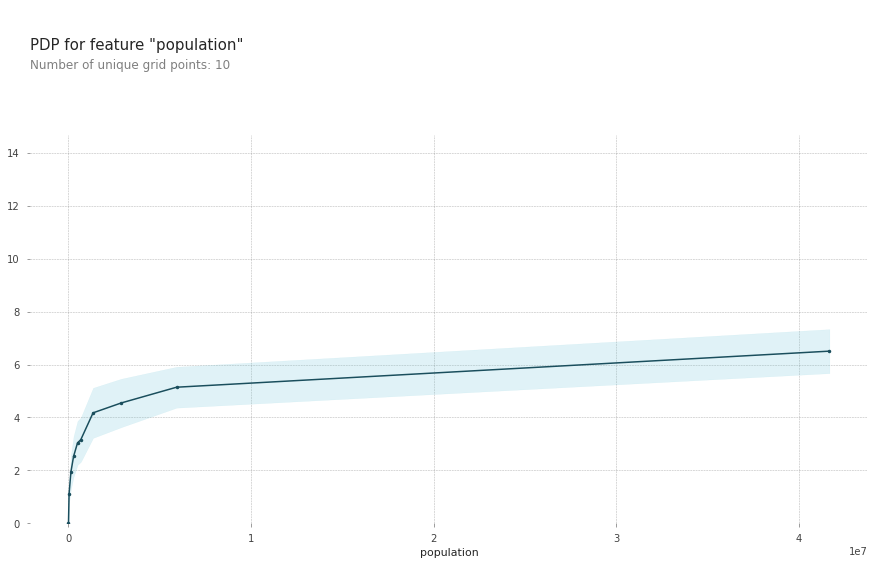

In [142]:
pdp_plot(isolated, feature_name=feature);

In [143]:
val.shape

(744, 9)

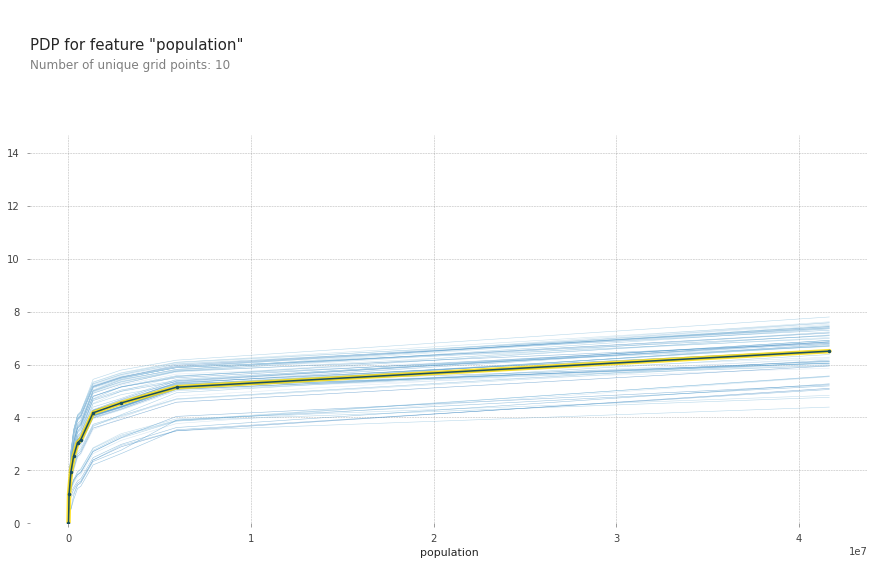

In [144]:
pdp_plot(isolated, feature_name=feature, plot_lines=True, frac_to_plot=0.1);


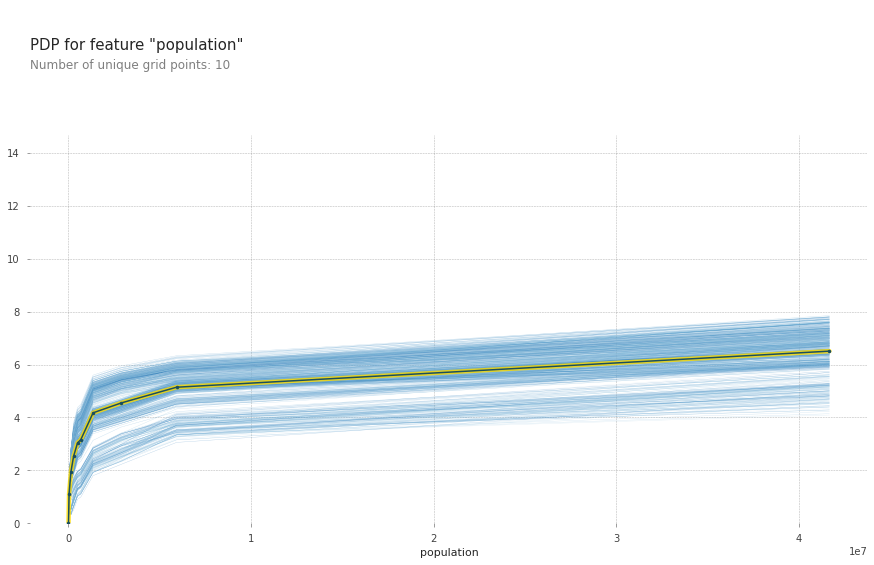

In [145]:
pdp_plot(isolated, feature_name=feature, plot_lines=True, frac_to_plot=1);

In [0]:
# Try changing num grid points
isolated = pdp_isolate(
    model=pipeline,
    dataset=X_val,
    model_features=X_val.columns,
    feature=feature,
    num_grid_points=50
)

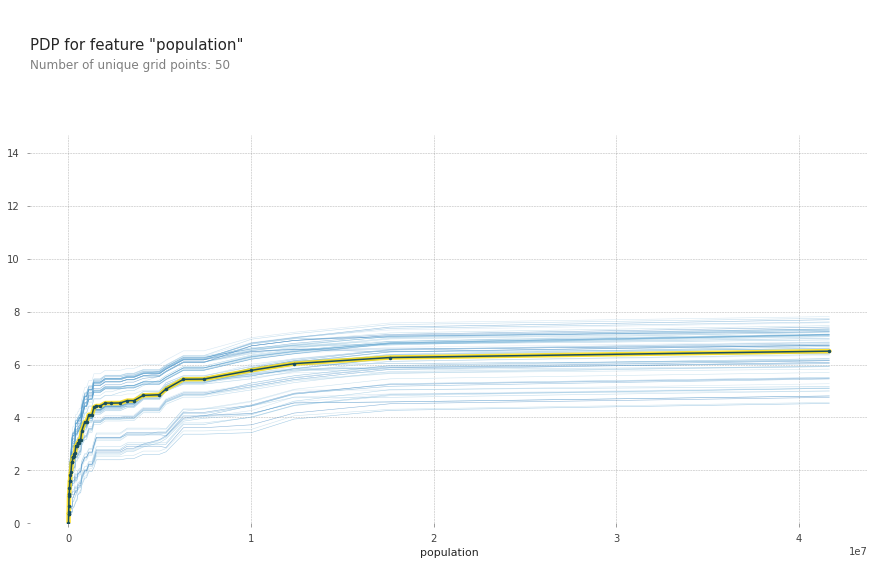

In [147]:
pdp_plot(isolated, feature_name=feature, plot_lines=True, frac_to_plot=0.1);


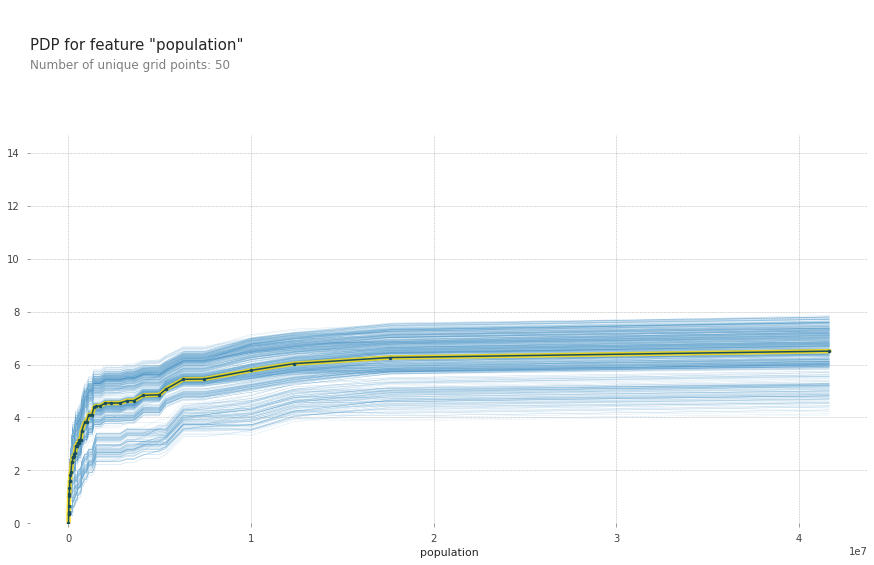

In [148]:
pdp_plot(isolated, feature_name=feature, plot_lines=True, frac_to_plot=1);


# Partial Dependence Plots with 2 Features

In [149]:
X_val.columns

Index(['country', 'sex', 'age', 'population', 'annual_gdp', 'gdp_per_capita'], dtype='object')

In [0]:
from pdpbox.pdp import pdp_interact, pdp_interact_plot

features = ['population', 'annual_gdp']

interaction = pdp_interact(
    model=pipeline,
    dataset=X_val,
    model_features=X_val.columns,
    features=features
)

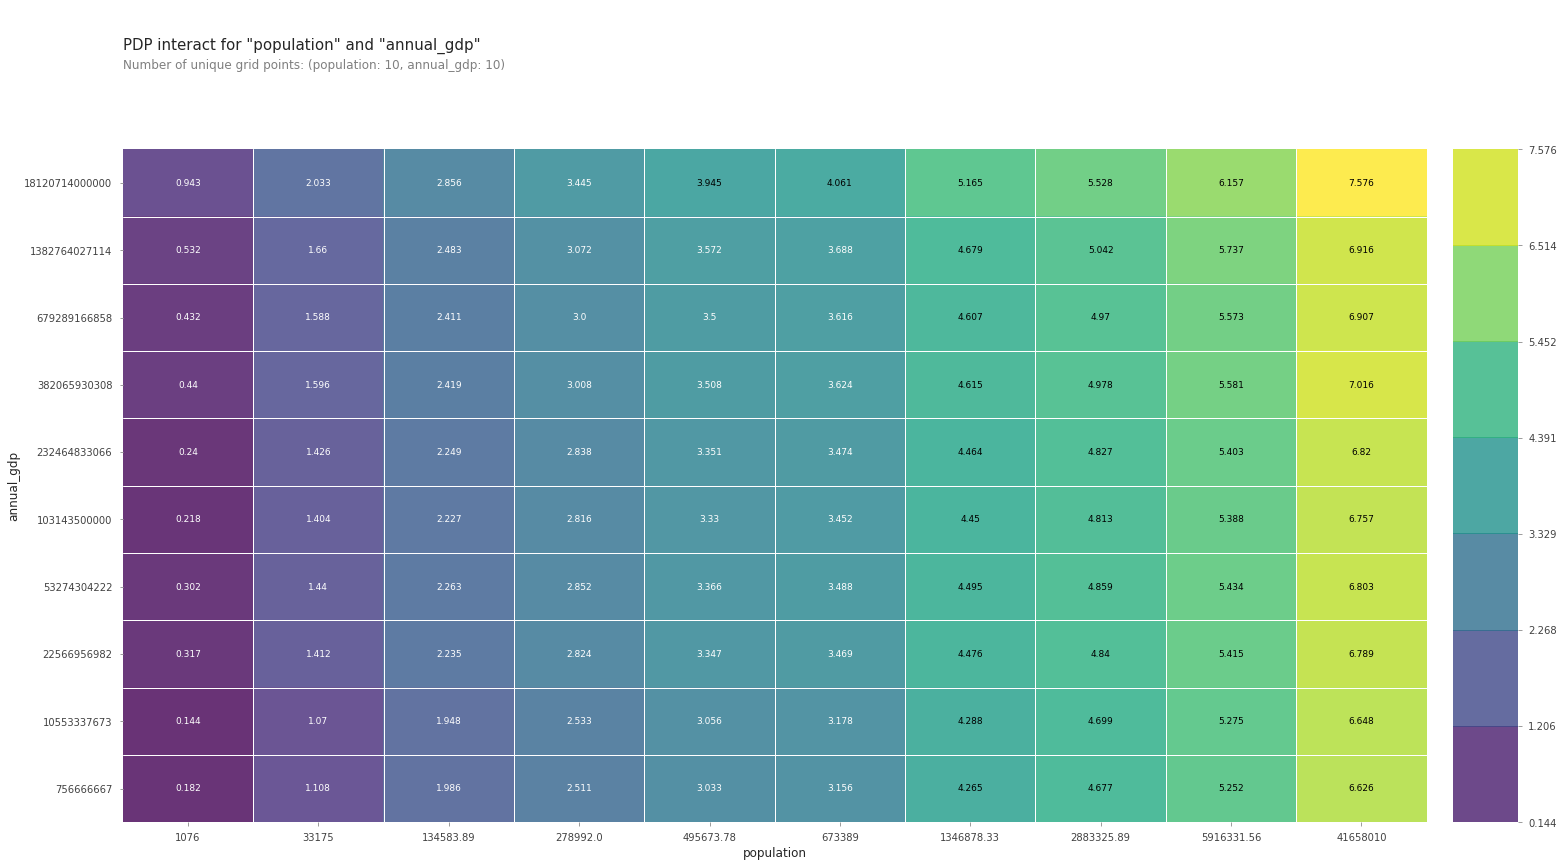

In [151]:
pdp_interact_plot(interaction, plot_type='grid', feature_names=features, figsize=[25, 15]);

# Partial Dependence Plots with Categorical Features

In [0]:
# Set target
target = 'log_num_suicides'

# Arrange data into X features matrix and y target vector
X_train = train.drop(columns=target)
y_train = train[target]
X_val = val.drop(columns=target)
y_val = val[target]
X_test = test.drop(columns=target)
y_test = test[target]

In [153]:
import seaborn as sns

encoder = ce.OrdinalEncoder()
X_train_encoded = encoder.fit_transform(X_train)
X_val_encoded = encoder.transform(X_val)

model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
model.fit(X_train_encoded, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=-1, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)

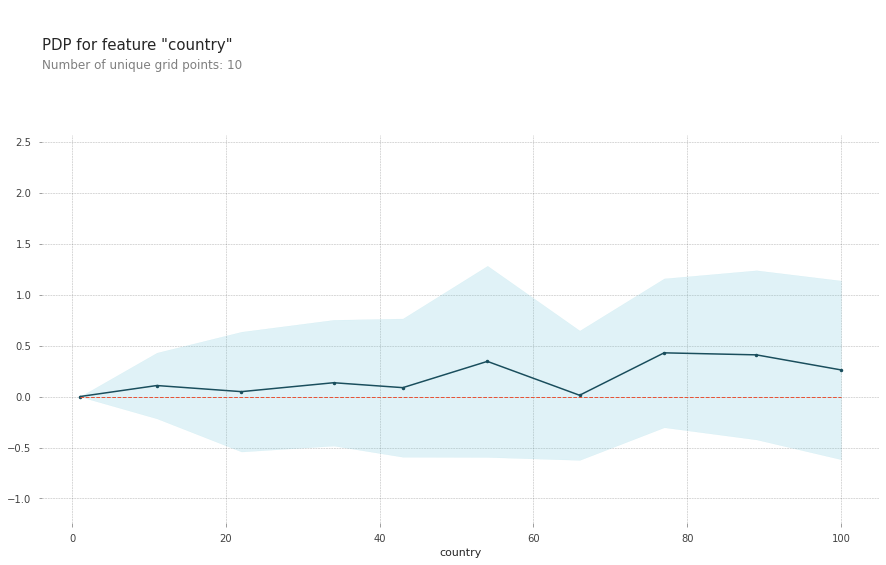

In [154]:
%matplotlib inline
import matplotlib.pyplot as plt
from pdpbox import pdp

feature = 'country'
pdp_dist = pdp.pdp_isolate(model=model,
                           dataset=X_train_encoded,
                           model_features=X_val_encoded.columns,
                           feature=feature)
pdp.pdp_plot(pdp_dist, feature);

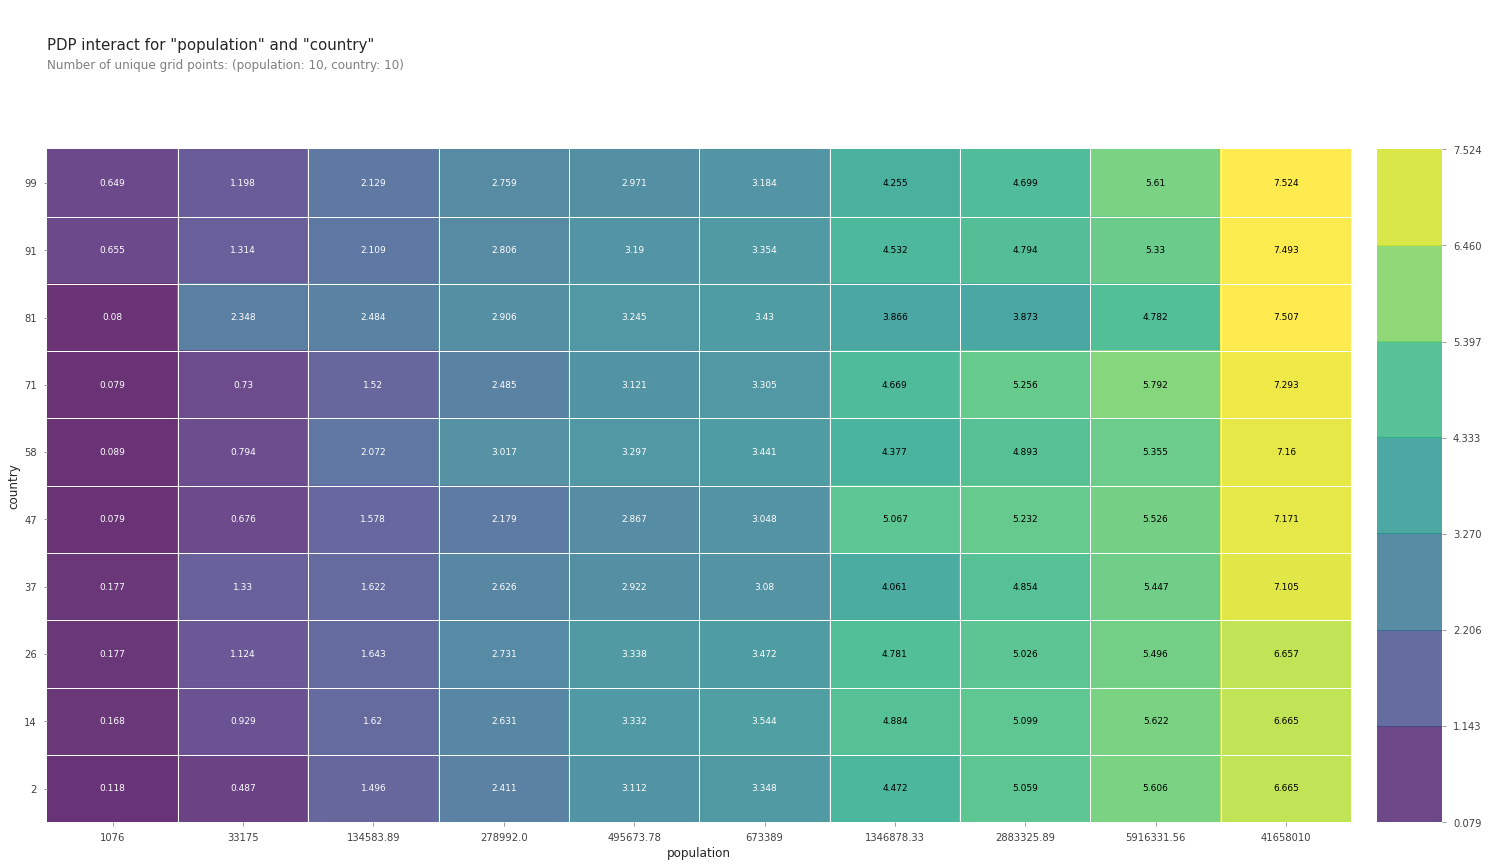

In [155]:
features = ['population', 'country']

interaction = pdp_interact(
    model=model,
    dataset=X_val_encoded,
    model_features=X_val_encoded.columns,
    features=features
)

pdp_interact_plot(interaction, plot_type='grid', feature_names=features, figsize=[25, 15]);

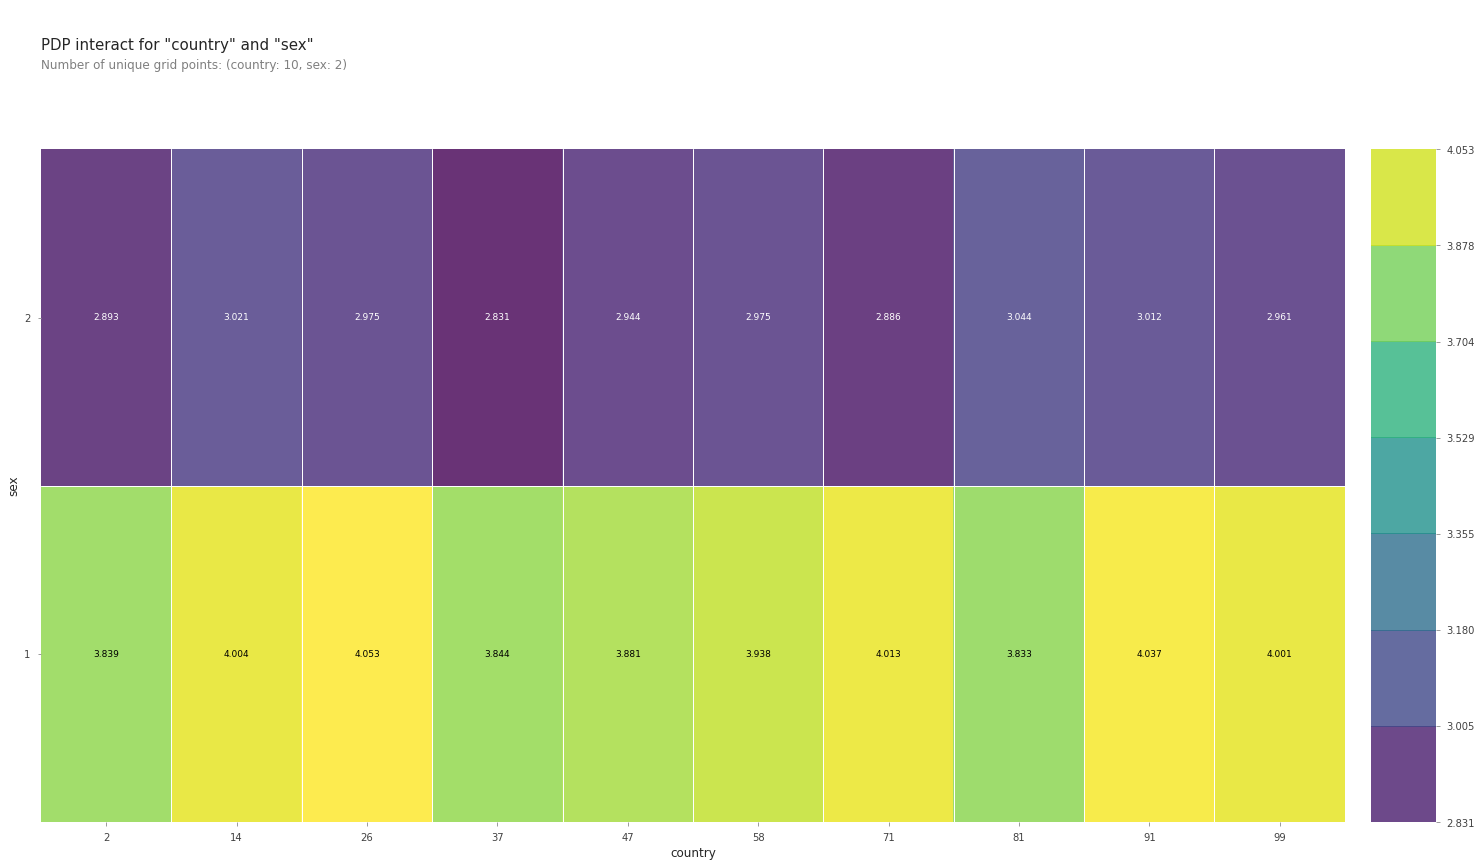

In [156]:
features = ['country', 'sex']

interaction = pdp_interact(
    model=model,
    dataset=X_val_encoded,
    model_features=X_val_encoded.columns,
    features=features
)

pdp_interact_plot(interaction, plot_type='grid', feature_names=features, figsize=[25, 15]);

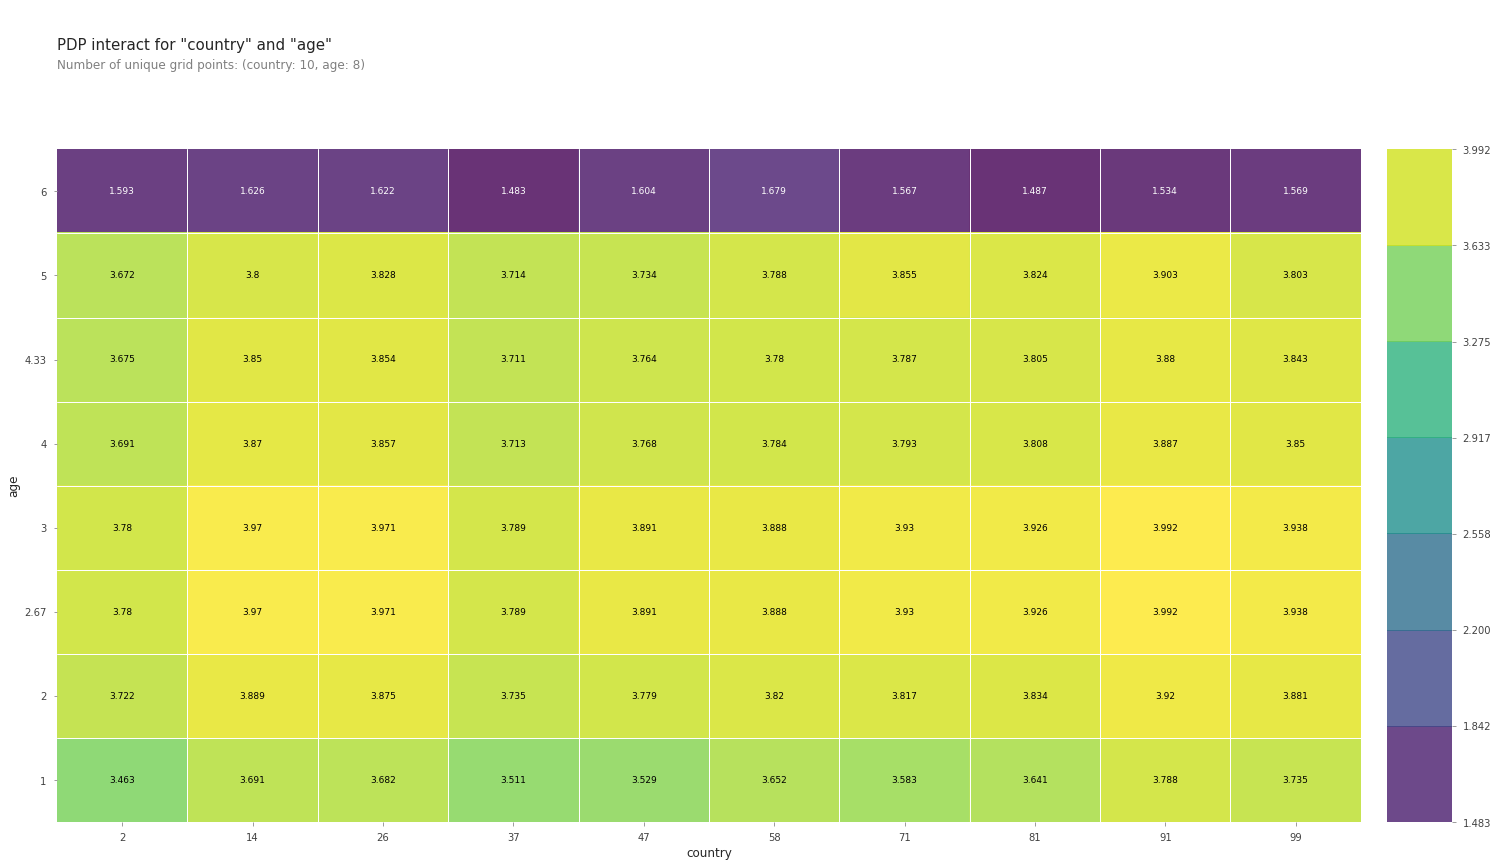

In [157]:
features = ['country', 'age']

interaction = pdp_interact(
    model=model,
    dataset=X_val_encoded,
    model_features=X_val_encoded.columns,
    features=features
)

pdp_interact_plot(interaction, plot_type='grid', feature_names=features, figsize=[25, 15]);

# Explain Individual Predictions with Shapley Balue Plots

In [158]:
from scipy.stats import randint, uniform
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV

param_distributions = {
    'n_estimators' : randint(50, 500),
    'max_depth' : [5, 10, 15, 20, None],
    'max_features' : uniform(0, 1)
}

search = RandomizedSearchCV(
    RandomForestRegressor(random_state=42),
    param_distributions=param_distributions,
    n_iter=5,
    cv=2,
    scoring='r2',
    verbose=10,
    return_train_score=True,
    n_jobs=-1,
    random_state=42
)

search.fit(X_train_encoded, y_train);

Fitting 2 folds for each of 5 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   12.6s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:   21.4s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   40.6s finished


In [159]:
print("Best hyperparameters", search.best_params_)
print("Cross Validation R^2", search.best_score_)
model = search.best_estimator_

Best hyperparameters {'max_depth': None, 'max_features': 0.596850157946487, 'n_estimators': 171}
Cross Validation R^2 0.7869719147827576


In [160]:
# Get individual observation to explain
row = X_test.iloc[[0]]
row

,country,year,sex,age,population,annual_gdp,gdp_per_capita,generation
1248,Armenia,2016,male,75+,61956,10546135160,3788,Silent


In [161]:
# What was the log_num_sucideds for this row?
y_test.iloc[[0]]

1248    2.564949
Name: log_num_suicides, dtype: float64

In [162]:
# What does the model predict for this row of data?
X_test_encoded = encoder.transform(X_test)
row = X_test_encoded.iloc[[0]]
model.predict(row)

array([1.88150585])

In [163]:
# Why did the model predict this? 
# Look at Shapley Values Force Plot
import shap

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(row)
shap_values

array([[-0.35580042, -0.02162327,  0.47907977,  0.28134949, -1.24016048,
        -0.53543322, -0.00951548,  0.0782397 ]])

In [164]:
# Create the force plot
shap.initjs()
shap.force_plot(
    base_value=explainer.expected_value,
    shap_values=shap_values,
    features=row
)

In [165]:
# Look at y_train mean
y_train.mean()

3.204729121205356

In [166]:
# Compare to expected value
explainer.expected_value

array([3.20536975])

In [167]:
# Look at shap value array
shap_values

array([[-0.35580042, -0.02162327,  0.47907977,  0.28134949, -1.24016048,
        -0.53543322, -0.00951548,  0.0782397 ]])

In [168]:
# Check train column names
X_train.columns

Index(['country', 'year', 'sex', 'age', 'population', 'annual_gdp',
       'gdp_per_capita', 'generation'],
      dtype='object')

In [169]:
# Refresh memory on prediction
model.predict(row)

array([1.88150585])

In [170]:
# Add up expected value with sum of shap values
explainer.expected_value + shap_values.sum()

array([1.88150585])